In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, classification_report
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Input,Reshape,GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from tqdm import tqdm
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.applications import VGG16
from keras.callbacks import Callback
from keras.applications import ResNet50
from tensorflow.keras.models import Model

In [2]:
img_size = 200

data_path = "../Data"

datas = os.listdir(os.path.join(data_path, "train"))
images_train = []
images_test = []
images_val = []

class_num = -1
for data in datas:
    class_num += 1
    for img in tqdm(os.listdir(os.path.join(data_path, "train", data)), desc=f"train data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "train", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_train.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "test", data)), desc=f"test data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "test", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_test.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "valid", data)), desc=f"val data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "valid", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_val.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    if class_num == 15:
        class_num += 1
        break

val data AMERICAN BITTERN --->: 100%|██████████| 5/5 [00:00<00:00, 319.91it/s]


In [3]:
X_train = []
y_train = []
for data in images_train:
    X_train.append(data["Image"])
    y_train.append(data["Class"])
X_test = []
y_test = []
for data in images_test:
    X_test.append(data["Image"])
    y_test.append(data["Class"])
X_val = []
y_val = []
for data in images_val:
    X_val.append(data["Image"])
    y_val.append(data["Class"])


X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)
X_val = np.array(X_val).reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

In [4]:
y_train_encoded = to_categorical(y_train, num_classes=class_num)
y_test_encoded = to_categorical(y_test, num_classes=class_num)
y_val_encoded = to_categorical(y_test, num_classes=class_num)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)
print(X_val.shape)
print(y_val.shape)
print(y_val_encoded.shape)

(2592, 200, 200, 3)
(2592,)
(2592, 16)
(80, 200, 200, 3)
(80,)
(80, 16)
(80, 200, 200, 3)
(80,)
(80, 16)


In [6]:
# Rebuild the ResNet50 model with correct input shape
pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                input_shape=(img_size, img_size, 3),
                                                pooling='avg',
                                                weights='imagenet')

i = 0
for layer in pretrained_model.layers:
    if i < 150: layer.trainable = False
    else: layer.trainable = True
    i += 1

resnet_model = Sequential()

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())


resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(16, activation='relu'))
resnet_model.add(Dense(class_num, activation='softmax'))

resnet_model.build((None, img_size, img_size, 3))

# Compile the model
resnet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Print model summary
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,156,288 (92.15 MB)

 Trainable params: 10,558,720 (40.28 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

In [7]:
model_history = resnet_model.fit(X_train, y_train_encoded, batch_size=128, epochs=10, validation_data=(X_val, y_val_encoded))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.0627 - loss: 2.7823 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1375 - val_loss: 3.1552 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 164s 8s/step - accuracy: 0.1100 - loss: 2.7243 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0625 - val_loss: 47.6580 - val_precision: 0.0625 - val_recall: 0.0625
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 171s 8s/step - accuracy: 0.1512 - loss: 2.5935 - precision: 0.8447 - recall: 0.0189 - val_accuracy: 0.0750 - val_loss: 81.4703 - val_precision: 0.0750 - val_recall: 0.0750
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.1613 - loss: 2.5061 - precision: 0.7363 - recall: 0.0311 - val_accuracy: 0.1375 - val_loss: 53.4826 - val_precision: 0.1375 - val_recall: 0.1375
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.1772 - loss: 2.3904 - precision: 0.8341 - recall: 0.0549 - val_accuracy:

In [14]:
prediction = resnet_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


In [15]:
pred = np.argmax(prediction, axis=1)

In [16]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.15


In [17]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.67      0.40      0.50         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.11      0.80      0.20         5
           7       0.00      0.00      0.00         5
           8       0.10      0.60      0.18         5
           9       0.00      0.00      0.00         5
          10       0.10      0.20      0.13         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       1.00      0.40      0.57         5

    accuracy                           0.15        80
   macro avg       0.12   

C:\Users\PC-ORBIT\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC-ORBIT\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC-ORBIT\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

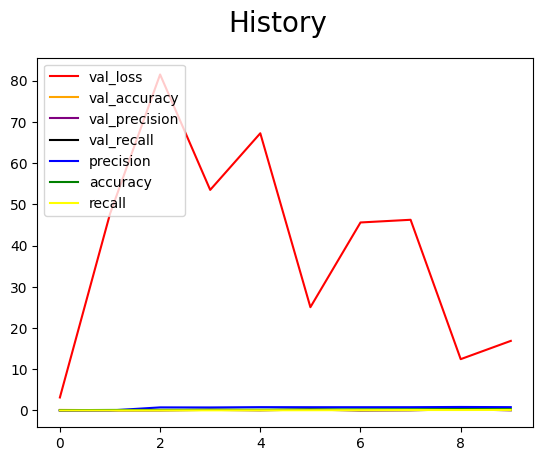

In [18]:
fig = plt.figure()
plt.plot(model_history.history["val_loss"], color='red', label="val_loss")
plt.plot(model_history.history["val_accuracy"], color='orange', label="val_accuracy")
plt.plot(model_history.history["val_precision"], color='purple', label="val_precision")
plt.plot(model_history.history["val_recall"], color='black', label="val_recall")
plt.plot(model_history.history["precision"], color='blue', label="precision")
plt.plot(model_history.history["accuracy"], color='green', label="accuracy")
plt.plot(model_history.history["recall"], color='yellow', label="recall")
fig.suptitle("History", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [19]:
resnet_model.save("../Models/resnet50.h5")